# Manual Implementation of Dropout in a Multilayer Artificial Neural Network using the PyTorch Library.







This notebook can be run in Google Colab, using the GPU provided by google.

 In this notebook, we manually (no torch.nn.Dropout) implement the Dropout method in a neural network using the PyTorch library. Additionally, three distinct models are trained. The first model is a neural network with a single intermediate layer, without dropout. The second model is identical to the first but incorporates dropout between the intermediate layer and the output layer, this implementation uses PyTorch's built-in nn.Module class for dropout. Finally, a third model is trained, this time with a manual implementation of dropout.

 The purpose of training three diverse models is to facilitate result comparison. The models are trained using the MNIST dataset.







## Neccesary Packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy.random import random
import pandas as pd
import datetime
import time
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cheking for gpu

In [4]:
torch.cuda.is_available()

True

### First Model, No DropOut

In [5]:
class Net(nn.Module):
    def __init__(self,n):
        super(Net,self).__init__()
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,n)
        #self.layer_two = nn.Linear(512,512)
        self.relu = nn.ReLU()
        self.layer_out = nn.Linear(n,10)

    def nombre(self):
        return 'SinDropout'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
       # x = self.layer_two(x)
        x = self.relu(x)
        x = self.layer_out(x)
        return x

In [6]:
x=torch.randn(1, 784)


In [7]:
model = Net(512)  #verifico que el modelo pueda predecir un input.
model(x)

tensor([[-0.0343, -0.1898,  0.1363,  0.1403,  0.0258,  0.0323, -0.0245, -0.3435,
          0.0088, -0.1299]], grad_fn=<AddmmBackward0>)

In [8]:
model.nombre()

'SinDropout'

### Second Model with Dropout Implemented Using the nn.Dropout Class

In [9]:
class DropOut(nn.Module):
    def __init__(self,p,n):
        super(DropOut,self).__init__()
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,n)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.layer_out = nn.Linear(n,10)

    def nombre(self):
        return 'DropOut'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [10]:
model2=DropOut(0.8,512)

In [11]:
model2.nombre()

'DropOut'

In [12]:
x = torch.randn(1,784)
model2(x)

tensor([[-0.2717,  0.0048,  0.3450, -0.1240,  0.7812,  0.1353,  0.1145, -0.1325,
          0.6639,  0.6681]], grad_fn=<AddmmBackward0>)

### Manual Implementation of Dropout within the forward() Method in PyTorch.

In [13]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape).to(device) >= dropout).float()
    #mask = torch.rand(X.shape) >= dropout   #esto no sirve xq tira a los elementos con False, no les asigna 0
    return mask*X / (1.0 - dropout)

In [14]:
X = torch.randn(64,784)

In [15]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
X= X.to(device)
#X = torch.randn(64,728)
print(X)
%time print('dropout_p = 0:', dropout_layer(X, 0))
%time print('dropout_p = 0.5:', dropout_layer(X, 0.5))
%time print('dropout_p = 1:', dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]], device='cuda:0')
dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]], device='cuda:0')
CPU times: user 4.01 ms, sys: 3 µs, total: 4.01 ms
Wall time: 8.05 ms
dropout_p = 0.5: tensor([[ 0.,  2.,  0.,  0.,  8., 10.,  0., 14.],
        [ 0., 18.,  0.,  0.,  0.,  0., 28., 30.]], device='cuda:0')
CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 6.42 ms
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
CPU times: user 5.77 ms, sys: 1.77 ms, total: 7.53 ms
Wall time: 15.1 ms


In [16]:
class ManualDropOut(nn.Module):
    def __init__(self,p,n):
        super(ManualDropOut,self).__init__()
        self.p = p
        self.n = n
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,self.n)
        self.relu = nn.ReLU()
        self.layer_out = nn.Linear(self.n,10)

    def nombre(self):
        return 'ManualDropOut'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
        x = self.relu(x)
        if self.training:
            x = dropout_layer(x,self.p)
        x = self.layer_out(x)
        return x

In [17]:
x = torch.randn(1,784).to(device)
modelo = ManualDropOut(0.5,512)
modelo.to(device)
modelo(x)

tensor([[ 0.0187, -0.0825, -0.1638, -0.0192, -0.1495,  0.4005, -0.1750,  0.1514,
         -0.5446,  0.2128]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [18]:
def prueba(model):
    return model.nombre()

In [19]:
prueba(modelo)

'ManualDropOut'

# Training, Validation, and Testing

### Below, the necessary code blocks are defined to execute the training and validation process.

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.to(device)
    # We iterate over batches.
    for batch, (X, y) in enumerate(dataloader):
        # We calculate the model prediction and the corresponding loss.
        X=X.to(device)
        y=y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # We backpropagate using the provided optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # We print the progress...
        # if batch % 100 == 0:
           # loss, current = loss.item(), batch * len(X)
            #print(f"batch={batch} loss={loss:>7f}  processed-samples:[{current:>5d}/{size:>5d}]")

# Similarly, we define the testing function, which will also be used for validation.
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # We set the model to evaluation mode. This is done to deactivate, for example, dropout, etc. when we are not in a training phase.
    model.eval()
    # We move the model to the GPU if available.
    model = model.to(device)
    # For validation, we disable gradient calculation.
    with torch.no_grad():
        for X,y in dataloader:
            # We move the tensors to the GPU if available.
            X = X.to(device)
            y = y.to(device)
            # We calculate the model predictions...
            pred = model(X)
            # ...and the corresponding losses, which we accumulate into a total value.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item() #el item va para convertir la loss de tensor a escalar
            # We also calculate the number of correct predictions and accumulate it into a total.
            num_samples += y.size(0)
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # We calculate the total loss and the fraction of correct classifications, and then print them.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [21]:
# We define training hyperparameters.
batch_size = 64
num_epochs = 40
lr =[0.1,0.01,0.001]
def train_validation(model,train_dataloader,valid_dataloader,df):
  for learning_rate in lr:
    # We create the model and the optimizer.
    try:
      modelo = model(0.3,512)
    except:
      modelo = model(512)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelo.parameters(),lr=learning_rate)
    # We train the model and calculate curves.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataloader,modelo,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataloader,modelo,loss_fn)
        valid_loss,valid_accu = test_loop(valid_dataloader,modelo,loss_fn)
        print(f"lr={learning_rate} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"Lr":learning_rate,
                         "epoch":epoch,
                         "train_loss":train_loss,
                         "train_accu":train_accu,
                          "valid_loss":valid_loss,
                          "valid_accu":valid_accu,
                        "model"     :modelo.nombre()}
                       ,ignore_index=True)
  return df

### Loading Dataset

In [22]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 171568629.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59614022.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49807288.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5223616.33it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Before running the models, a test is conducted using a single sample from the training and validation sets to verify that everything is functioning correctly.

#### I define the Dataset class, which allows me to manipulate the data used to feed the models.

In [23]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X
        self.Y = torch.tensor(Y)
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        return self.X, self.Y

In [24]:
train_ejemplo = Dataset(train_dataset[0][0],train_dataset[0][1]) #creo el dataset con el primer dato que descargamos de MNIST

In [25]:
X,y=next(iter(train_ejemplo)) #chequeo que el objeto sea iterable como se espera

In [26]:
X.size() #compruebo dimensiones

torch.Size([1, 28, 28])

In [27]:
type(y)

torch.Tensor

In [28]:
y.size()

torch.Size([])

In [29]:
y

tensor(5)

In [30]:
len(train_ejemplo) #cheching len()

1

In [31]:
type(train_ejemplo[1][0]) #checking datatype

torch.Tensor

In [32]:
train_ejemplo_loader = torch.utils.data.DataLoader(train_ejemplo)

In [33]:
for batch,(X,y) in enumerate(train_ejemplo_loader):   #I finish verifying that the implementation works
                                                      #for this training data.






    print(batch,X,y)

0 tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

In [34]:
y.size()

torch.Size([1])

In [35]:
val_ejemplo = Dataset(train_dataset[1][0],train_dataset[1][1])

In [36]:
val_ejemplo_loader = torch.utils.data.DataLoader(val_ejemplo)

In [37]:
for batch,(X,y) in enumerate(val_ejemplo_loader):
    print(batch,X,y)

0 tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

#### Now, I proceed with the test, training each model with only one data point.

In [ ]:
df_prueba = pd.DataFrame()

%time  train_validation(Net,train_ejemplo_loader,val_ejemplo_loader,df_prueba)

In [ ]:
df_prueba2 = pd.DataFrame()
%time  train_validation(DropOut,train_ejemplo_loader,val_ejemplo_loader,df_prueba2)

In [ ]:
df_prueba3 = pd.DataFrame()
#model = ManualDropOut(1,512)
%time  train_validation(ManualDropOut,train_ejemplo_loader,val_ejemplo_loader,df_prueba3)

### Now we train and validate each model



## No dropout

In [ ]:
#model Net(512)
df_sin = pd.DataFrame()
df_sin = train_validation(Net,train_loader,test_loader,df_sin)

In [ ]:
df1 = df_sin.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()
#df3

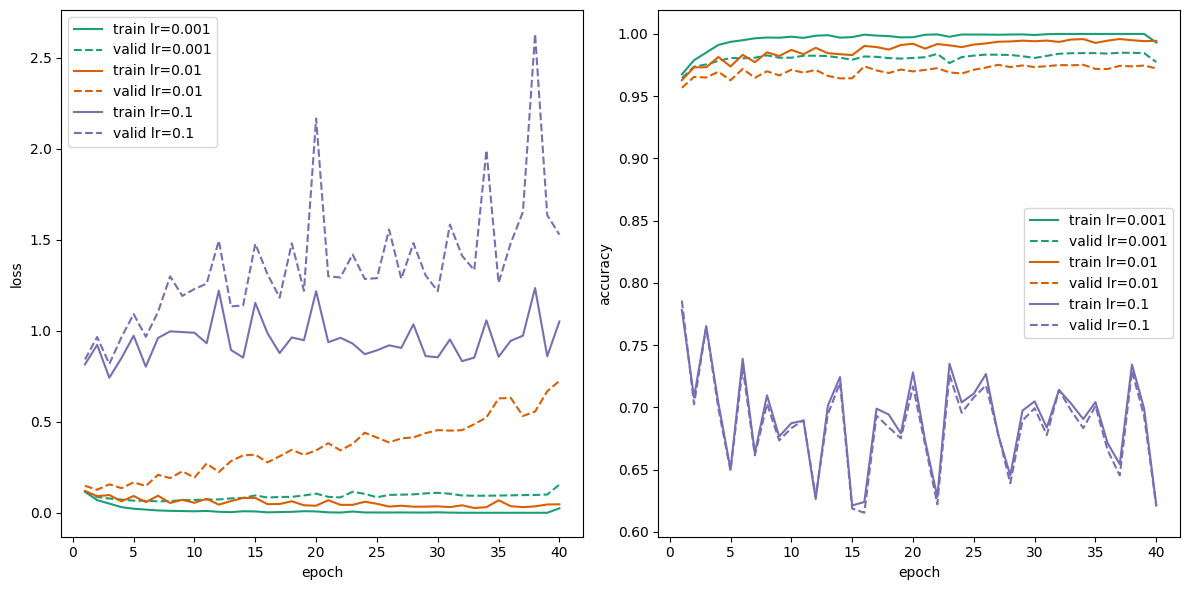

In [43]:
from matplotlib import cm
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df1["Lr"].unique()):
    dfn = df1[df1["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

##  ManualDropOut().

In [44]:
df_manual = pd.DataFrame()
# model ManualDropOut(0.2,512)

In [ ]:
#modelo_manual.to(device)
df_manual = train_validation(ManualDropOut,train_loader,test_loader,df_manual)

In [ ]:
df3 = df_manual.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()

#df3

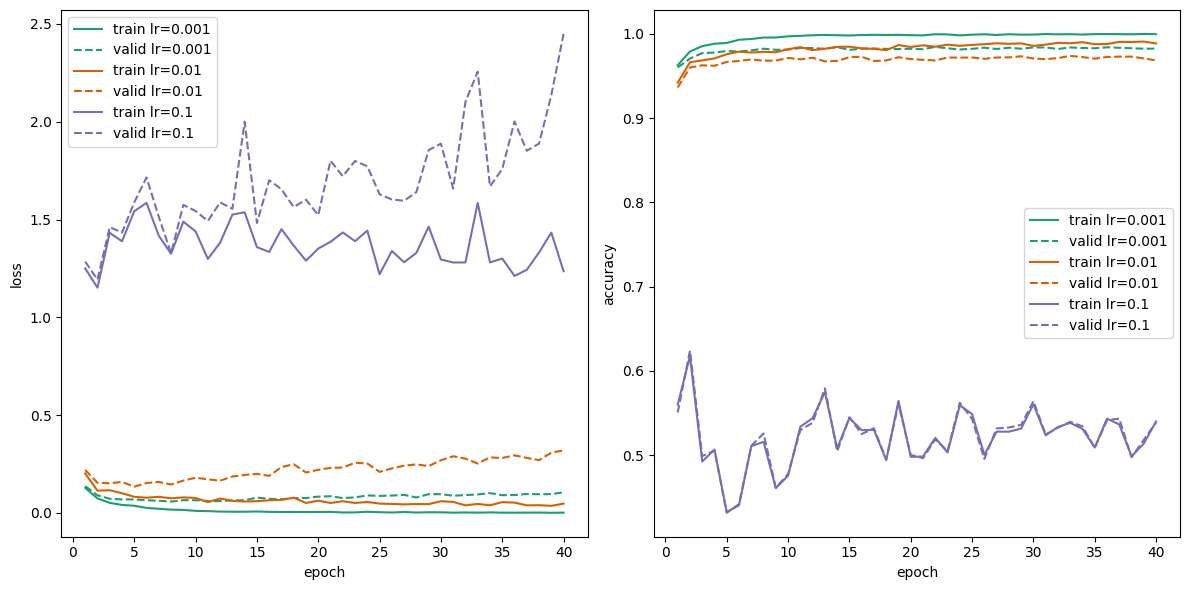

In [47]:
from matplotlib import cm
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df3["Lr"].unique()):
    dfn = df3[df3["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

## Pytorch's Dropout

In [ ]:
df_dropout = pd.DataFrame()
# model DropOut(0.2,512)
df_dropout = train_validation(DropOut,train_loader,test_loader,df_dropout)

In [ ]:
df2 = df_dropout.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()

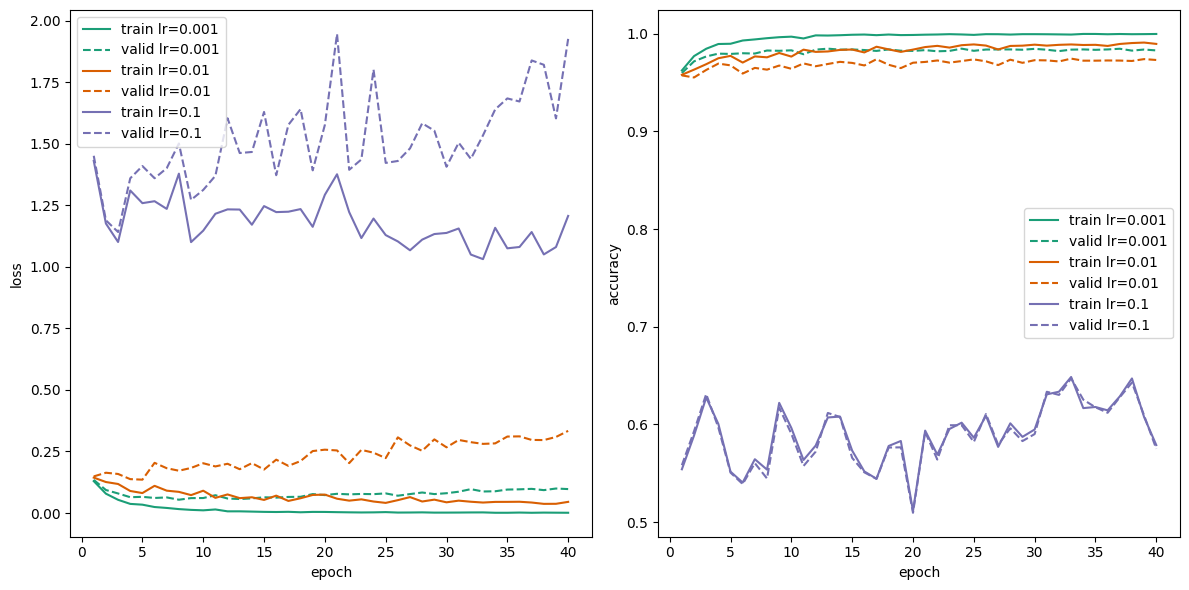

In [50]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df2["Lr"].unique()):
    dfn = df2[df2["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()